In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import pandas as pd
from datetime import datetime

import plotting
import data_higgs as dh

import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras
print("TF Keras version ",tf.keras.__version__)

from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from catboost import CatBoostClassifier, Pool

TensorFlow version  2.10.1
TF Keras version  2.10.0


# MFP Strojno učenje

In [2]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 100

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [3]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data 
    #prepare the data => normalizations !   

    # split 
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only
    
    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling 
    data_x = (data_x - mu)/s

    #scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    #data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

## Boosted decision trees

Loading c:\Users\lotri\Downloads\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


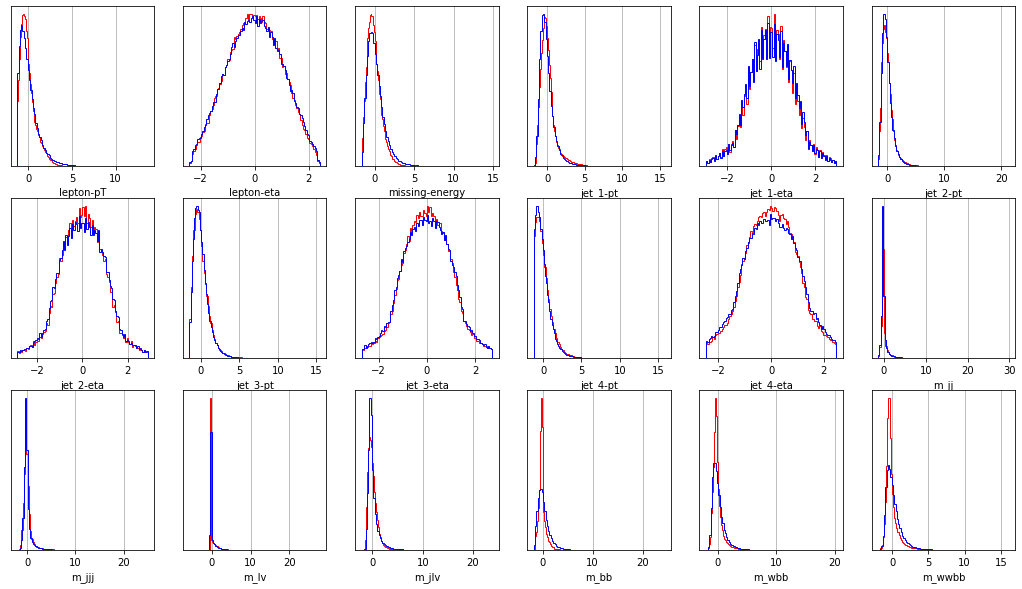

In [4]:

#dh.download_and_make_data()

hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

#plot distributions
plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

# ready the data for Catboost
pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())

#NaKratko .... ! 

# CatBoost parameters 
eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
task_type = 'CPU'  # if GPU else 'CPU'


def trees_params(max_depth, nepoch):
    max_number_of_trees = nepoch
    #eval_metric = 'Accuracy'
    bdt=CatBoostClassifier(
        verbose=True,
        task_type=task_type,
        loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
        iterations=max_number_of_trees,
        eval_metric=eval_metric,
        learning_rate=0.01,
        max_depth=6,
        use_best_model=False,
        random_seed=SEED_VALUE,
        )   

    #now train the model
    bdt.fit(
            pool_train,
            early_stopping_rounds=20,
            #is early stopping relevant?
            eval_set=pool_test,
            plot=True # works when called through Ipython/jupyter
        )

    return bdt

In [5]:
def parameters_impact():
    auc_max_depth = list()
    auc_max_number_of_trees = list()
    
    
    for max_depth in range(2,20,2):
        bdt = trees_params(max_depth, 500)
        y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
        auc_max_depth.append(roc_auc_score(y_val,y_score))
        
            
    for max_number_of_trees in range(50,500,10):
        bdt = trees_params(10, max_number_of_trees)
        y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
        auc_max_number_of_trees.append(roc_auc_score(y_val,y_score))
        
        
    return auc_max_depth, auc_max_number_of_trees

auc_max_depth, auc_max_number_of_trees = parameters_impact()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 284ms	remaining: 2m 21s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 462ms	remaining: 1m 54s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 774ms	remaining: 2m 8s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 898ms	remaining: 1m 51s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 1.02s	remaining: 1m 40s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.15s	remaining: 1m 34s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.28s	remaining: 1m 29s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.41s	remaining: 1m 26s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.54s	remaining: 1m 24s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.68s	remaining: 1m 22s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.81s	remaining: 1m 20s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.94s	remaining: 1m 18s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.07s	remaining: 1m 17s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.21s	remaining: 1m 16s
14:	test: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 167ms	remaining: 1m 23s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 346ms	remaining: 1m 26s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 513ms	remaining: 1m 24s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 657ms	remaining: 1m 21s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 763ms	remaining: 1m 15s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 882ms	remaining: 1m 12s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.03s	remaining: 1m 12s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.15s	remaining: 1m 10s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.28s	remaining: 1m 9s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.47s	remaining: 1m 12s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.6s	remaining: 1m 11s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.72s	remaining: 1m 9s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.86s	remaining: 1m 9s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.03s	remaining: 1m 10s
14:	test: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 132ms	remaining: 1m 5s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 268ms	remaining: 1m 6s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 457ms	remaining: 1m 15s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 609ms	remaining: 1m 15s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 772ms	remaining: 1m 16s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 916ms	remaining: 1m 15s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.07s	remaining: 1m 15s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.2s	remaining: 1m 13s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.36s	remaining: 1m 14s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.51s	remaining: 1m 13s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.7s	remaining: 1m 15s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.89s	remaining: 1m 17s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.14s	remaining: 1m 20s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.33s	remaining: 1m 20s
14:	test: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 170ms	remaining: 1m 24s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 342ms	remaining: 1m 25s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 659ms	remaining: 1m 49s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 816ms	remaining: 1m 41s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 974ms	remaining: 1m 36s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.1s	remaining: 1m 30s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.25s	remaining: 1m 28s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.43s	remaining: 1m 27s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.63s	remaining: 1m 29s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.75s	remaining: 1m 26s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.9s	remaining: 1m 24s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.06s	remaining: 1m 23s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.35s	remaining: 1m 27s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.48s	remaining: 1m 25s
14:	test: 0.73

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 133ms	remaining: 1m 6s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 257ms	remaining: 1m 4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 368ms	remaining: 1m
3:	test: 0.7255668	best: 0.7255668 (3)	total: 506ms	remaining: 1m 2s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 639ms	remaining: 1m 3s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 766ms	remaining: 1m 3s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 891ms	remaining: 1m 2s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.01s	remaining: 1m 2s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.15s	remaining: 1m 2s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.28s	remaining: 1m 2s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.42s	remaining: 1m 3s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.56s	remaining: 1m 3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.7s	remaining: 1m 3s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.82s	remaining: 1m 3s
14:	test: 0.7300112	best: 0.73

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 121ms	remaining: 1m
1:	test: 0.7203550	best: 0.7203550 (1)	total: 259ms	remaining: 1m 4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 458ms	remaining: 1m 15s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 647ms	remaining: 1m 20s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 775ms	remaining: 1m 16s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 898ms	remaining: 1m 13s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.04s	remaining: 1m 13s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.18s	remaining: 1m 12s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.31s	remaining: 1m 11s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.44s	remaining: 1m 10s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.58s	remaining: 1m 10s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.75s	remaining: 1m 11s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.9s	remaining: 1m 11s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.04s	remaining: 1m 10s
14:	test: 0.730011

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 135ms	remaining: 1m 7s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 240ms	remaining: 59.7s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 337ms	remaining: 55.8s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 479ms	remaining: 59.4s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 622ms	remaining: 1m 1s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 743ms	remaining: 1m 1s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 872ms	remaining: 1m 1s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 998ms	remaining: 1m 1s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.13s	remaining: 1m 1s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.27s	remaining: 1m 2s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.42s	remaining: 1m 3s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.61s	remaining: 1m 5s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.76s	remaining: 1m 6s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.94s	remaining: 1m 7s
14:	test: 0.7300112	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 98.5ms	remaining: 49.1s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 210ms	remaining: 52.3s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 322ms	remaining: 53.4s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 514ms	remaining: 1m 3s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 680ms	remaining: 1m 7s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 820ms	remaining: 1m 7s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 930ms	remaining: 1m 5s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.02s	remaining: 1m 2s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.16s	remaining: 1m 3s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.26s	remaining: 1m 1s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.38s	remaining: 1m 1s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.5s	remaining: 1m
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.63s	remaining: 1m
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.74s	remaining: 1m
14:	test: 0.7300112	best: 0.7300112

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 119ms	remaining: 59.2s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 304ms	remaining: 1m 15s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 483ms	remaining: 1m 19s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 648ms	remaining: 1m 20s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 799ms	remaining: 1m 19s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 928ms	remaining: 1m 16s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.06s	remaining: 1m 14s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.18s	remaining: 1m 12s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.33s	remaining: 1m 12s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.49s	remaining: 1m 12s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.62s	remaining: 1m 11s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.76s	remaining: 1m 11s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.89s	remaining: 1m 10s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.03s	remaining: 1m 10s
14:	test: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 80.4ms	remaining: 3.94s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 156ms	remaining: 3.75s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 232ms	remaining: 3.63s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 352ms	remaining: 4.04s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 442ms	remaining: 3.98s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 525ms	remaining: 3.85s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 625ms	remaining: 3.84s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 707ms	remaining: 3.71s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 782ms	remaining: 3.56s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 865ms	remaining: 3.46s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 972ms	remaining: 3.45s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.05s	remaining: 3.33s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.15s	remaining: 3.28s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.23s	remaining: 3.16s
14:	test: 0.7293030	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 77.6ms	remaining: 4.58s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 165ms	remaining: 4.79s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 239ms	remaining: 4.55s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 320ms	remaining: 4.47s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 426ms	remaining: 4.68s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 513ms	remaining: 4.62s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 710ms	remaining: 5.38s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 812ms	remaining: 5.28s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 892ms	remaining: 5.06s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 1s	remaining: 5s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.08s	remaining: 4.8s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.17s	remaining: 4.67s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.25s	remaining: 4.54s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.34s	remaining: 4.4s
14:	test: 0.7293030	best: 0.72930

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 79.2ms	remaining: 5.46s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 156ms	remaining: 5.29s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 236ms	remaining: 5.27s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 323ms	remaining: 5.32s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 418ms	remaining: 5.43s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 510ms	remaining: 5.44s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 616ms	remaining: 5.54s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 691ms	remaining: 5.35s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 795ms	remaining: 5.38s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 885ms	remaining: 5.31s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 987ms	remaining: 5.29s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.1s	remaining: 5.31s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.24s	remaining: 5.43s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.37s	remaining: 5.49s
14:	test: 0.7293030	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 79.2ms	remaining: 6.26s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 152ms	remaining: 5.93s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 227ms	remaining: 5.82s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 305ms	remaining: 5.79s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 408ms	remaining: 6.12s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 491ms	remaining: 6.05s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 646ms	remaining: 6.74s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 754ms	remaining: 6.79s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 841ms	remaining: 6.63s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 923ms	remaining: 6.46s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.01s	remaining: 6.37s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.11s	remaining: 6.28s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.19s	remaining: 6.11s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.28s	remaining: 6.06s
14:	test: 0.7293030	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 79.1ms	remaining: 7.04s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 154ms	remaining: 6.76s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 230ms	remaining: 6.66s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 305ms	remaining: 6.56s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 475ms	remaining: 8.08s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 592ms	remaining: 8.28s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 668ms	remaining: 7.91s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 747ms	remaining: 7.66s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 824ms	remaining: 7.41s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 1.01s	remaining: 8.07s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.11s	remaining: 8.01s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.19s	remaining: 7.74s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.31s	remaining: 7.75s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.41s	remaining: 7.67s
14:	test: 0.7293030	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 100ms	remaining: 9.91s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 193ms	remaining: 9.48s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 281ms	remaining: 9.07s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 391ms	remaining: 9.38s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 498ms	remaining: 9.46s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 609ms	remaining: 9.54s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 694ms	remaining: 9.22s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 794ms	remaining: 9.13s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 885ms	remaining: 8.95s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 988ms	remaining: 8.89s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.07s	remaining: 8.66s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.16s	remaining: 8.53s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.25s	remaining: 8.36s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.34s	remaining: 8.23s
14:	test: 0.7293030	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 100ms	remaining: 10.9s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 202ms	remaining: 10.9s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 303ms	remaining: 10.8s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 434ms	remaining: 11.5s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 542ms	remaining: 11.4s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 671ms	remaining: 11.6s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 774ms	remaining: 11.4s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 911ms	remaining: 11.6s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 1.01s	remaining: 11.4s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 1.19s	remaining: 11.9s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.38s	remaining: 12.4s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.56s	remaining: 12.8s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.72s	remaining: 12.8s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.82s	remaining: 12.5s
14:	test: 0.7293030	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 95ms	remaining: 11.3s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 192ms	remaining: 11.3s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 305ms	remaining: 11.9s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 431ms	remaining: 12.5s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 559ms	remaining: 12.9s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 675ms	remaining: 12.8s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 797ms	remaining: 12.9s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 935ms	remaining: 13.1s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 1.1s	remaining: 13.5s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 1.22s	remaining: 13.4s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.34s	remaining: 13.3s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.49s	remaining: 13.4s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.62s	remaining: 13.3s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.73s	remaining: 13.1s
14:	test: 0.7293030	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 80.2ms	remaining: 10.3s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 155ms	remaining: 9.93s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 226ms	remaining: 9.58s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 302ms	remaining: 9.52s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 402ms	remaining: 10.1s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 486ms	remaining: 10s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 588ms	remaining: 10.3s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 671ms	remaining: 10.2s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 821ms	remaining: 11s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 974ms	remaining: 11.7s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.1s	remaining: 11.9s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.2s	remaining: 11.8s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.3s	remaining: 11.7s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.39s	remaining: 11.5s
14:	test: 0.7293030	best: 0.7293

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 79.5ms	remaining: 11s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 157ms	remaining: 10.8s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 232ms	remaining: 10.6s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 312ms	remaining: 10.6s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 410ms	remaining: 11.1s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 494ms	remaining: 11s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 602ms	remaining: 11.4s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 678ms	remaining: 11.2s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 772ms	remaining: 11.2s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 858ms	remaining: 11.2s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 937ms	remaining: 11s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.02s	remaining: 10.9s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.11s	remaining: 10.9s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.21s	remaining: 10.9s
14:	test: 0.7293030	best: 0.729

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 74.9ms	remaining: 11.2s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 149ms	remaining: 11s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 227ms	remaining: 11.1s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 310ms	remaining: 11.3s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 422ms	remaining: 12.2s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 551ms	remaining: 13.2s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 700ms	remaining: 14.3s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 879ms	remaining: 15.6s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 974ms	remaining: 15.3s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 1.05s	remaining: 14.7s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.14s	remaining: 14.4s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.22s	remaining: 14.1s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.3s	remaining: 13.7s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.4s	remaining: 13.6s
14:	test: 0.7293030	best: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 77.1ms	remaining: 12.3s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 153ms	remaining: 12.1s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 224ms	remaining: 11.7s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 299ms	remaining: 11.7s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 404ms	remaining: 12.5s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 488ms	remaining: 12.5s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 589ms	remaining: 12.9s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 672ms	remaining: 12.8s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 771ms	remaining: 12.9s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 850ms	remaining: 12.8s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 947ms	remaining: 12.8s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.04s	remaining: 12.8s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.11s	remaining: 12.6s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.21s	remaining: 12.6s
14:	test: 0.7293030	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 86.5ms	remaining: 14.6s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 167ms	remaining: 14s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 247ms	remaining: 13.8s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 363ms	remaining: 15.1s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 456ms	remaining: 15.1s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 545ms	remaining: 14.9s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 656ms	remaining: 15.3s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 739ms	remaining: 15s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 840ms	remaining: 15s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 920ms	remaining: 14.7s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.04s	remaining: 15.1s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.13s	remaining: 14.9s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.21s	remaining: 14.7s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.3s	remaining: 14.4s
14:	test: 0.7293030	best: 0.7293

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 100ms	remaining: 17.9s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 179ms	remaining: 16s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 270ms	remaining: 15.9s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 366ms	remaining: 16.1s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 470ms	remaining: 16.4s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 558ms	remaining: 16.2s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 702ms	remaining: 17.4s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 821ms	remaining: 17.7s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 969ms	remaining: 18.4s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 1.12s	remaining: 19s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.22s	remaining: 18.7s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.3s	remaining: 18.3s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.41s	remaining: 18.1s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.49s	remaining: 17.7s
14:	test: 0.7293030	best: 0.729

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 82.8ms	remaining: 15.6s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 157ms	remaining: 14.7s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 229ms	remaining: 14.3s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 311ms	remaining: 14.5s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 418ms	remaining: 15.5s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 499ms	remaining: 15.3s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 604ms	remaining: 15.8s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 681ms	remaining: 15.5s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 778ms	remaining: 15.6s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 862ms	remaining: 15.5s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 966ms	remaining: 15.7s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.14s	remaining: 16.8s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.24s	remaining: 16.9s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.31s	remaining: 16.5s
14:	test: 0.7293030	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 94.7ms	remaining: 18.8s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 195ms	remaining: 19.3s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 287ms	remaining: 18.9s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 423ms	remaining: 20.7s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 528ms	remaining: 20.6s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 657ms	remaining: 21.2s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 770ms	remaining: 21.2s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 884ms	remaining: 21.2s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 999ms	remaining: 21.2s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.12s	remaining: 21.2s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.22s	remaining: 21s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.35s	remaining: 21.1s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.45s	remaining: 20.9s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.59s	remaining: 21.1s
14:	test: 0.7300112	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 153ms	remaining: 32s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 692ms	remaining: 1m 11s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 1.1s	remaining: 1m 16s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 1.48s	remaining: 1m 16s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 1.72s	remaining: 1m 10s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.86s	remaining: 1m 3s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.98s	remaining: 57.5s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 2.1s	remaining: 53s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 2.22s	remaining: 49.6s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 2.35s	remaining: 47s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 2.52s	remaining: 45.6s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.69s	remaining: 44.5s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 3.01s	remaining: 45.6s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 3.14s	remaining: 44s
14:	test: 0.7300112	best: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 107ms	remaining: 23.4s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 208ms	remaining: 22.7s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 300ms	remaining: 21.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 437ms	remaining: 23.6s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 550ms	remaining: 23.6s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 676ms	remaining: 24.1s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 876ms	remaining: 26.7s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 988ms	remaining: 26.2s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.14s	remaining: 26.7s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.25s	remaining: 26.2s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.35s	remaining: 25.8s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.49s	remaining: 25.8s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.6s	remaining: 25.4s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.72s	remaining: 25.3s
14:	test: 0.7300112	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 102ms	remaining: 23.4s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 205ms	remaining: 23.4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 300ms	remaining: 22.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 462ms	remaining: 26.1s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 569ms	remaining: 25.6s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 697ms	remaining: 26s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 808ms	remaining: 25.7s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 920ms	remaining: 25.5s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.04s	remaining: 25.5s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.15s	remaining: 25.4s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.26s	remaining: 25s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.39s	remaining: 25.3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.52s	remaining: 25.4s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.64s	remaining: 25.3s
14:	test: 0.7300112	best: 0.73

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 112ms	remaining: 26.9s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 240ms	remaining: 28.6s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 335ms	remaining: 26.5s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 459ms	remaining: 27.1s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 563ms	remaining: 26.5s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 687ms	remaining: 26.8s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 801ms	remaining: 26.7s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 919ms	remaining: 26.7s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.05s	remaining: 27s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.16s	remaining: 26.8s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.28s	remaining: 26.7s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.45s	remaining: 27.5s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.63s	remaining: 28.5s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.78s	remaining: 28.8s
14:	test: 0.7300112	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 118ms	remaining: 29.3s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 231ms	remaining: 28.6s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 397ms	remaining: 32.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 530ms	remaining: 32.6s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 636ms	remaining: 31.1s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 762ms	remaining: 31s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 878ms	remaining: 30.5s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 991ms	remaining: 30s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.11s	remaining: 29.8s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.23s	remaining: 29.6s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.34s	remaining: 29.1s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.48s	remaining: 29.3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.59s	remaining: 29s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.7s	remaining: 28.7s
14:	test: 0.7300112	best: 0.73001

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 265ms	remaining: 1m 8s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 615ms	remaining: 1m 19s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 1.16s	remaining: 1m 39s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 1.37s	remaining: 1m 27s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 1.81s	remaining: 1m 32s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 2.5s	remaining: 1m 46s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 2.83s	remaining: 1m 42s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 3.07s	remaining: 1m 36s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 3.45s	remaining: 1m 36s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 3.76s	remaining: 1m 34s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 3.97s	remaining: 1m 29s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 4.22s	remaining: 1m 27s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 4.42s	remaining: 1m 24s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 4.72s	remaining: 1m 22s
14:	test: 0.73

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 141ms	remaining: 37.9s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 293ms	remaining: 39.3s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 397ms	remaining: 35.3s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 510ms	remaining: 33.9s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 605ms	remaining: 32.1s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 725ms	remaining: 31.9s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 837ms	remaining: 31.4s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 952ms	remaining: 31.2s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.07s	remaining: 31s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.17s	remaining: 30.4s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.28s	remaining: 30.2s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.45s	remaining: 31.2s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.58s	remaining: 31.2s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.69s	remaining: 30.9s
14:	test: 0.7300112	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 142ms	remaining: 39.5s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 292ms	remaining: 40.6s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 398ms	remaining: 36.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 518ms	remaining: 35.8s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 609ms	remaining: 33.5s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 712ms	remaining: 32.5s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 818ms	remaining: 31.9s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 910ms	remaining: 30.9s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.01s	remaining: 30.4s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.11s	remaining: 29.9s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.21s	remaining: 29.5s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.3s	remaining: 29.2s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.46s	remaining: 30.1s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.58s	remaining: 30.1s
14:	test: 0.7300112	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 94.9ms	remaining: 27.4s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 206ms	remaining: 29.7s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 311ms	remaining: 29.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 417ms	remaining: 29.8s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 514ms	remaining: 29.3s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 614ms	remaining: 29.1s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 711ms	remaining: 28.8s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 810ms	remaining: 28.5s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 949ms	remaining: 29.6s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.09s	remaining: 30.6s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.2s	remaining: 30.4s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.31s	remaining: 30.3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.41s	remaining: 30s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.52s	remaining: 30s
14:	test: 0.7300112	best: 0.73

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 113ms	remaining: 33.7s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 211ms	remaining: 31.5s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 302ms	remaining: 29.9s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 419ms	remaining: 31s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 516ms	remaining: 30.5s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 621ms	remaining: 30.4s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 716ms	remaining: 30s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 811ms	remaining: 29.6s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 921ms	remaining: 29.8s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.02s	remaining: 29.5s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.13s	remaining: 29.6s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.23s	remaining: 29.5s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.33s	remaining: 29.4s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.44s	remaining: 29.3s
14:	test: 0.7300112	best: 0.73

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 91.6ms	remaining: 28.3s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 189ms	remaining: 29.1s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 278ms	remaining: 28.5s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 383ms	remaining: 29.3s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 497ms	remaining: 30.3s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 700ms	remaining: 35.5s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 801ms	remaining: 34.7s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 922ms	remaining: 34.8s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.05s	remaining: 35s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.14s	remaining: 34.2s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.24s	remaining: 33.8s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.34s	remaining: 33.3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.44s	remaining: 33s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.55s	remaining: 32.9s
14:	test: 0.7300112	best: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 101ms	remaining: 32.1s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 200ms	remaining: 31.8s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 309ms	remaining: 32.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 425ms	remaining: 33.6s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 521ms	remaining: 32.8s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 629ms	remaining: 32.9s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 723ms	remaining: 32.3s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 816ms	remaining: 31.8s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 925ms	remaining: 32s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.02s	remaining: 31.6s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.13s	remaining: 31.7s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.23s	remaining: 31.6s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.33s	remaining: 31.5s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.44s	remaining: 31.4s
14:	test: 0.7300112	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 99.9ms	remaining: 32.9s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 200ms	remaining: 32.9s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 290ms	remaining: 31.6s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 401ms	remaining: 32.7s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 493ms	remaining: 32s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 597ms	remaining: 32.2s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 695ms	remaining: 32.1s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 788ms	remaining: 31.7s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 893ms	remaining: 31.9s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 997ms	remaining: 31.9s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.14s	remaining: 33.1s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.26s	remaining: 33.5s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.36s	remaining: 33.2s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.46s	remaining: 33s
14:	test: 0.7300112	best: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 99ms	remaining: 33.6s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 200ms	remaining: 33.8s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 290ms	remaining: 32.6s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 504ms	remaining: 42.3s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 607ms	remaining: 40.7s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 706ms	remaining: 39.3s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 804ms	remaining: 38.3s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 901ms	remaining: 37.4s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.09s	remaining: 40.1s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.23s	remaining: 40.7s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.34s	remaining: 40.1s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.44s	remaining: 39.3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.55s	remaining: 39s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.66s	remaining: 38.7s
14:	test: 0.7300112	best: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 110ms	remaining: 38.5s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 216ms	remaining: 37.5s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 306ms	remaining: 35.4s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 433ms	remaining: 37.5s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 525ms	remaining: 36.2s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 638ms	remaining: 36.6s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 738ms	remaining: 36.2s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 831ms	remaining: 35.5s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 963ms	remaining: 36.5s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.07s	remaining: 36.3s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.17s	remaining: 36.1s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.27s	remaining: 35.9s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.38s	remaining: 35.7s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.47s	remaining: 35.3s
14:	test: 0.7300112	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 189ms	remaining: 1m 7s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 318ms	remaining: 56.9s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 668ms	remaining: 1m 19s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 852ms	remaining: 1m 15s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 982ms	remaining: 1m 9s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.12s	remaining: 1m 6s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.24s	remaining: 1m 2s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.33s	remaining: 58.6s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.45s	remaining: 56.4s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.55s	remaining: 54.1s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.65s	remaining: 52.3s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.76s	remaining: 51.2s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.88s	remaining: 50.2s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.98s	remaining: 49s
14:	test: 0.7300112	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 137ms	remaining: 50.4s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 288ms	remaining: 53s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 391ms	remaining: 47.9s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 494ms	remaining: 45.2s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 588ms	remaining: 42.9s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 688ms	remaining: 41.8s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 783ms	remaining: 40.6s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 884ms	remaining: 40s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 983ms	remaining: 39.4s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.08s	remaining: 38.8s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.18s	remaining: 38.5s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.28s	remaining: 38.4s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.44s	remaining: 39.4s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.55s	remaining: 39.6s
14:	test: 0.7300112	best: 0.73

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 117ms	remaining: 44.3s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 236ms	remaining: 44.7s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 353ms	remaining: 44.4s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 499ms	remaining: 46.9s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 615ms	remaining: 46.1s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 729ms	remaining: 45.5s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 986ms	remaining: 52.6s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.25s	remaining: 58s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.48s	remaining: 1m
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.65s	remaining: 1m
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.77s	remaining: 59.4s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.88s	remaining: 57.6s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2s	remaining: 56.6s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.13s	remaining: 55.8s
14:	test: 0.7300112	best: 0.7300112 (

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 102ms	remaining: 39.6s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 207ms	remaining: 40.2s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 310ms	remaining: 40s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 495ms	remaining: 47.8s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 674ms	remaining: 51.9s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 802ms	remaining: 51.3s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.04s	remaining: 56.8s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.16s	remaining: 55.4s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.29s	remaining: 54.7s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.41s	remaining: 53.6s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.54s	remaining: 52.9s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.67s	remaining: 52.6s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.8s	remaining: 52.4s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.94s	remaining: 52s
14:	test: 0.7300112	best: 0.730

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 98.9ms	remaining: 39.5s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 215ms	remaining: 42.8s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 312ms	remaining: 41.3s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 459ms	remaining: 45.5s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 568ms	remaining: 44.8s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 725ms	remaining: 47.6s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.02s	remaining: 57.3s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.12s	remaining: 55s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.23s	remaining: 53.4s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.36s	remaining: 53.2s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.52s	remaining: 53.7s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.65s	remaining: 53.4s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.78s	remaining: 53.2s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.91s	remaining: 52.7s
14:	test: 0.7300112	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 153ms	remaining: 1m 2s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 302ms	remaining: 1m 1s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 432ms	remaining: 58.6s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 1.05s	remaining: 1m 46s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 1.27s	remaining: 1m 42s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.46s	remaining: 1m 38s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.62s	remaining: 1m 33s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.83s	remaining: 1m 31s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.99s	remaining: 1m 28s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 2.17s	remaining: 1m 26s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 2.3s	remaining: 1m 23s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.44s	remaining: 1m 20s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.57s	remaining: 1m 18s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.72s	remaining: 1m 16s
14:	test: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 172ms	remaining: 1m 12s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 396ms	remaining: 1m 22s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 697ms	remaining: 1m 36s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 925ms	remaining: 1m 36s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 1.06s	remaining: 1m 27s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.19s	remaining: 1m 21s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.47s	remaining: 1m 26s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.65s	remaining: 1m 25s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.82s	remaining: 1m 23s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.94s	remaining: 1m 19s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 2.06s	remaining: 1m 16s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.19s	remaining: 1m 14s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.33s	remaining: 1m 12s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.46s	remaining: 1m 11s
14:	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 133ms	remaining: 56.8s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 254ms	remaining: 54.4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 361ms	remaining: 51.4s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 513ms	remaining: 54.7s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 627ms	remaining: 53.3s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 871ms	remaining: 1m 1s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.02s	remaining: 1m 1s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.15s	remaining: 1m
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.26s	remaining: 59.2s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.41s	remaining: 59.1s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.55s	remaining: 58.9s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.74s	remaining: 1m
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.93s	remaining: 1m 1s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.14s	remaining: 1m 3s
14:	test: 0.7300112	best: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 106ms	remaining: 46.6s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 214ms	remaining: 46.9s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 377ms	remaining: 54.9s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 572ms	remaining: 1m 2s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 786ms	remaining: 1m 8s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 913ms	remaining: 1m 6s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.02s	remaining: 1m 3s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.14s	remaining: 1m 1s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.27s	remaining: 1m
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.52s	remaining: 1m 5s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.66s	remaining: 1m 4s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.81s	remaining: 1m 4s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.99s	remaining: 1m 5s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.13s	remaining: 1m 4s
14:	test: 0.7300112	best: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 120ms	remaining: 53.7s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 225ms	remaining: 50.4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 337ms	remaining: 50.2s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 474ms	remaining: 52.9s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 585ms	remaining: 52.1s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 716ms	remaining: 53s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 970ms	remaining: 1m 1s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.09s	remaining: 1m
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.2s	remaining: 59s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.33s	remaining: 58.8s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.46s	remaining: 58.3s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.6s	remaining: 58.3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.73s	remaining: 58s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.85s	remaining: 57.6s
14:	test: 0.7300112	best: 0.7300112 (

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 167ms	remaining: 1m 16s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 323ms	remaining: 1m 13s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 530ms	remaining: 1m 20s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 644ms	remaining: 1m 13s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 745ms	remaining: 1m 7s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.01s	remaining: 1m 16s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.16s	remaining: 1m 15s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.29s	remaining: 1m 13s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.49s	remaining: 1m 14s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.63s	remaining: 1m 13s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.75s	remaining: 1m 11s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.87s	remaining: 1m 9s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2s	remaining: 1m 8s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.13s	remaining: 1m 7s
14:	test: 0.7300112

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 102ms	remaining: 47.8s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 252ms	remaining: 58.9s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 490ms	remaining: 1m 16s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 669ms	remaining: 1m 17s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 790ms	remaining: 1m 13s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 905ms	remaining: 1m 10s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.02s	remaining: 1m 7s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.15s	remaining: 1m 6s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.42s	remaining: 1m 12s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.54s	remaining: 1m 10s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.66s	remaining: 1m 9s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.85s	remaining: 1m 10s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.01s	remaining: 1m 10s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.14s	remaining: 1m 9s
14:	test: 0.730011

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 186ms	remaining: 1m 29s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 310ms	remaining: 1m 14s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 427ms	remaining: 1m 7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 566ms	remaining: 1m 7s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 694ms	remaining: 1m 5s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 926ms	remaining: 1m 13s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.08s	remaining: 1m 12s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.2s	remaining: 1m 10s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.39s	remaining: 1m 12s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.57s	remaining: 1m 13s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.71s	remaining: 1m 12s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.81s	remaining: 1m 10s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.93s	remaining: 1m 9s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.06s	remaining: 1m 8s
14:	test: 0.730011

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 97.3ms	remaining: 47.6s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 203ms	remaining: 49.6s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 304ms	remaining: 49.4s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 445ms	remaining: 54.1s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 563ms	remaining: 54.6s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 697ms	remaining: 56.3s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 824ms	remaining: 56.9s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 993ms	remaining: 59.8s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.22s	remaining: 1m 4s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.33s	remaining: 1m 3s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.44s	remaining: 1m 2s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.58s	remaining: 1m 2s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.71s	remaining: 1m 2s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.89s	remaining: 1m 4s
14:	test: 0.7300112	best:

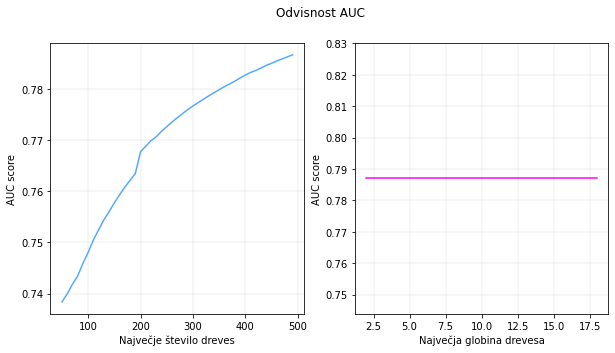

In [6]:
# ........ metrics - hyperparameters
cmap = plt.get_cmap('cool', 4)

max_depth = range(2,20,2)
max_number_of_trees = range(50,500,10)

fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.suptitle("Odvisnost AUC")

ax[0].grid(lw = 0.2)
ax[1].grid(lw = 0.2)

ax[0].set_xlabel("Največje število dreves")
ax[0].set_ylabel("AUC score")
ax[0].plot(max_number_of_trees, auc_max_number_of_trees, color=cmap(1))
ax[1].set_xlabel("Največja globina drevesa")
ax[1].set_ylabel("AUC score")
ax[1].plot(max_depth, auc_max_depth, color=cmap(3))

plt.savefig('grafi/metrics_hyperparameters_AUC.pdf')
plt.show()

In [ ]:
# time used vs auc 
from datetime import datetime

time_complexity = list()
auc_metrics = list()

for max_number_of_trees in range(50,1000,50):
    start = datetime.now()
    
    bdt = trees_params(50, max_number_of_trees) # max depth set to default 6
    
    time_complexity.append((datetime.now()- start).total_seconds())
    
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    auc_metrics.append(roc_auc_score(y_val,y_score))

for max_number_of_trees in range(1500,3000,500):
    start = datetime.now()
    
    bdt = trees_params(50, max_number_of_trees) # max depth set to 50
    
    time_complexity.append((datetime.now()- start).total_seconds())
    
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    auc_metrics.append(roc_auc_score(y_val,y_score))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 118ms	remaining: 5.76s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 203ms	remaining: 4.88s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 289ms	remaining: 4.52s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 383ms	remaining: 4.4s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 484ms	remaining: 4.36s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 574ms	remaining: 4.21s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 659ms	remaining: 4.05s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 748ms	remaining: 3.93s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 838ms	remaining: 3.82s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 925ms	remaining: 3.7s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.01s	remaining: 3.58s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.1s	remaining: 3.48s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.19s	remaining: 3.4s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.28s	remaining: 3.3s
14:	test: 0.7293030	best: 0.729

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 106ms	remaining: 10.5s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 196ms	remaining: 9.61s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 286ms	remaining: 9.25s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 375ms	remaining: 8.99s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 464ms	remaining: 8.82s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 561ms	remaining: 8.78s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 647ms	remaining: 8.6s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 746ms	remaining: 8.58s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 846ms	remaining: 8.55s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 942ms	remaining: 8.48s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.03s	remaining: 8.35s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.13s	remaining: 8.26s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.22s	remaining: 8.16s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.31s	remaining: 8.04s
14:	test: 0.7293030	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 94.4ms	remaining: 14.1s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 188ms	remaining: 13.9s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 277ms	remaining: 13.6s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 376ms	remaining: 13.7s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 472ms	remaining: 13.7s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 581ms	remaining: 13.9s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 670ms	remaining: 13.7s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 766ms	remaining: 13.6s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 859ms	remaining: 13.5s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 951ms	remaining: 13.3s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.04s	remaining: 13.2s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 1.14s	remaining: 13.1s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 1.25s	remaining: 13.2s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 1.34s	remaining: 13.1s
14:	test: 0.7293030	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 184ms	remaining: 36.5s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 359ms	remaining: 35.5s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 522ms	remaining: 34.2s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 681ms	remaining: 33.4s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 867ms	remaining: 33.8s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.03s	remaining: 33.3s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.21s	remaining: 33.4s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.38s	remaining: 33.1s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.58s	remaining: 33.4s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.81s	remaining: 34.5s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 2.11s	remaining: 36.2s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.38s	remaining: 37.3s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.58s	remaining: 37.1s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.76s	remaining: 36.6s
14:	test: 0.7300112	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 177ms	remaining: 44.2s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 385ms	remaining: 47.7s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 556ms	remaining: 45.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 729ms	remaining: 44.8s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 896ms	remaining: 43.9s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.08s	remaining: 43.8s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.27s	remaining: 44.2s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.43s	remaining: 43.4s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.6s	remaining: 42.8s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.77s	remaining: 42.5s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.95s	remaining: 42.3s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.19s	remaining: 43.4s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.5s	remaining: 45.7s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.76s	remaining: 46.6s
14:	test: 0.7300112	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 126ms	remaining: 37.6s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 254ms	remaining: 37.9s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 444ms	remaining: 43.9s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 655ms	remaining: 48.5s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 807ms	remaining: 47.6s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 938ms	remaining: 46s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.07s	remaining: 44.8s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.19s	remaining: 43.6s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.34s	remaining: 43.4s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.47s	remaining: 42.8s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.61s	remaining: 42.2s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.74s	remaining: 41.7s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.93s	remaining: 42.7s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.06s	remaining: 42.1s
14:	test: 0.7300112	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 199ms	remaining: 1m 9s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 373ms	remaining: 1m 4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 513ms	remaining: 59.4s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 640ms	remaining: 55.3s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 755ms	remaining: 52.1s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 880ms	remaining: 50.4s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.02s	remaining: 49.9s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.13s	remaining: 48.4s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.26s	remaining: 47.8s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.46s	remaining: 49.7s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.59s	remaining: 49.1s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.72s	remaining: 48.5s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.85s	remaining: 48s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.99s	remaining: 47.9s
14:	test: 0.7300112	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 136ms	remaining: 54.1s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 276ms	remaining: 55s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 394ms	remaining: 52.1s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 538ms	remaining: 53.3s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 667ms	remaining: 52.7s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 812ms	remaining: 53.3s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 954ms	remaining: 53.6s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.08s	remaining: 52.9s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.22s	remaining: 52.8s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.34s	remaining: 52.4s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.48s	remaining: 52.4s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.61s	remaining: 52.2s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.76s	remaining: 52.6s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.9s	remaining: 52.3s
14:	test: 0.7300112	best: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 132ms	remaining: 59.2s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 261ms	remaining: 58.5s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 387ms	remaining: 57.7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 531ms	remaining: 59.2s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 650ms	remaining: 57.9s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 777ms	remaining: 57.5s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 906ms	remaining: 57.3s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.02s	remaining: 56.6s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.16s	remaining: 56.6s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.28s	remaining: 56.5s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.44s	remaining: 57.4s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.57s	remaining: 57.5s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.71s	remaining: 57.5s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.83s	remaining: 57.2s
14:	test: 0.7300112	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 186ms	remaining: 1m 32s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 342ms	remaining: 1m 25s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 469ms	remaining: 1m 17s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 605ms	remaining: 1m 15s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 718ms	remaining: 1m 11s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 841ms	remaining: 1m 9s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 961ms	remaining: 1m 7s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.07s	remaining: 1m 5s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.19s	remaining: 1m 5s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.32s	remaining: 1m 4s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.45s	remaining: 1m 4s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.59s	remaining: 1m 4s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.71s	remaining: 1m 4s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.84s	remaining: 1m 3s
14:	test: 0.7300112	b

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 114ms	remaining: 1m 2s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 238ms	remaining: 1m 5s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 371ms	remaining: 1m 7s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 491ms	remaining: 1m 7s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 619ms	remaining: 1m 7s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 739ms	remaining: 1m 6s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 858ms	remaining: 1m 6s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 970ms	remaining: 1m 5s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.1s	remaining: 1m 6s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.22s	remaining: 1m 6s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.35s	remaining: 1m 6s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.52s	remaining: 1m 8s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.73s	remaining: 1m 11s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.91s	remaining: 1m 12s
14:	test: 0.7300112	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 169ms	remaining: 1m 41s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 375ms	remaining: 1m 52s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 538ms	remaining: 1m 46s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 715ms	remaining: 1m 46s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 873ms	remaining: 1m 43s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.05s	remaining: 1m 43s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.22s	remaining: 1m 43s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.39s	remaining: 1m 42s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.69s	remaining: 1m 51s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.96s	remaining: 1m 55s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 2.17s	remaining: 1m 56s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.36s	remaining: 1m 55s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.54s	remaining: 1m 54s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.78s	remaining: 1m 56s
14:	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 294ms	remaining: 3m 10s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 542ms	remaining: 2m 55s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 714ms	remaining: 2m 33s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 898ms	remaining: 2m 25s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 1.08s	remaining: 2m 19s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 1.25s	remaining: 2m 14s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.43s	remaining: 2m 11s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.7s	remaining: 2m 16s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.91s	remaining: 2m 16s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 2.1s	remaining: 2m 14s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 2.28s	remaining: 2m 12s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 2.47s	remaining: 2m 11s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 2.65s	remaining: 2m 9s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.83s	remaining: 2m 8s
14:	test: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 155ms	remaining: 1m 48s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 374ms	remaining: 2m 10s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 566ms	remaining: 2m 11s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 697ms	remaining: 2m 1s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 817ms	remaining: 1m 53s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 957ms	remaining: 1m 50s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.09s	remaining: 1m 48s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.21s	remaining: 1m 45s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.35s	remaining: 1m 43s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.48s	remaining: 1m 41s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.67s	remaining: 1m 44s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.83s	remaining: 1m 45s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.97s	remaining: 1m 43s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 2.09s	remaining: 1m 42s
14:	test: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 124ms	remaining: 1m 32s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 251ms	remaining: 1m 33s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 376ms	remaining: 1m 33s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 518ms	remaining: 1m 36s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 662ms	remaining: 1m 38s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 854ms	remaining: 1m 45s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 1.06s	remaining: 1m 52s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.18s	remaining: 1m 49s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.3s	remaining: 1m 47s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.43s	remaining: 1m 45s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.56s	remaining: 1m 44s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.69s	remaining: 1m 44s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.82s	remaining: 1m 43s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.95s	remaining: 1m 42s
14:	test: 0.7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 125ms	remaining: 1m 39s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 260ms	remaining: 1m 43s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 372ms	remaining: 1m 38s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 506ms	remaining: 1m 40s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 629ms	remaining: 1m 39s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 796ms	remaining: 1m 45s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 955ms	remaining: 1m 48s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.07s	remaining: 1m 45s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.21s	remaining: 1m 46s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.32s	remaining: 1m 44s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.45s	remaining: 1m 44s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.59s	remaining: 1m 44s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.72s	remaining: 1m 44s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.86s	remaining: 1m 44s
14:	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 121ms	remaining: 1m 43s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 244ms	remaining: 1m 43s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 365ms	remaining: 1m 43s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 490ms	remaining: 1m 43s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 620ms	remaining: 1m 44s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 746ms	remaining: 1m 44s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 873ms	remaining: 1m 45s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 986ms	remaining: 1m 43s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.11s	remaining: 1m 44s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.31s	remaining: 1m 50s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.51s	remaining: 1m 55s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.68s	remaining: 1m 57s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.81s	remaining: 1m 56s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.93s	remaining: 1m 55s
14:	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 129ms	remaining: 1m 55s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 258ms	remaining: 1m 55s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 376ms	remaining: 1m 52s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 524ms	remaining: 1m 57s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 644ms	remaining: 1m 55s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 774ms	remaining: 1m 55s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 904ms	remaining: 1m 55s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 1.04s	remaining: 1m 55s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 1.17s	remaining: 1m 55s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.29s	remaining: 1m 55s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.43s	remaining: 1m 55s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.57s	remaining: 1m 56s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.72s	remaining: 1m 57s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.84s	remaining: 1m 56s
14:	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 127ms	remaining: 2m
1:	test: 0.7203550	best: 0.7203550 (1)	total: 285ms	remaining: 2m 15s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 375ms	remaining: 1m 58s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 484ms	remaining: 1m 54s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 584ms	remaining: 1m 50s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 683ms	remaining: 1m 47s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 773ms	remaining: 1m 44s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 858ms	remaining: 1m 40s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 952ms	remaining: 1m 39s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.04s	remaining: 1m 37s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.13s	remaining: 1m 36s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.22s	remaining: 1m 35s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.34s	remaining: 1m 36s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.48s	remaining: 1m 39s
14:	test: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 87.7ms	remaining: 2m 11s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 186ms	remaining: 2m 19s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 269ms	remaining: 2m 14s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 385ms	remaining: 2m 24s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 495ms	remaining: 2m 28s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 611ms	remaining: 2m 32s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 727ms	remaining: 2m 35s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 815ms	remaining: 2m 32s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 907ms	remaining: 2m 30s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1s	remaining: 2m 29s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.1s	remaining: 2m 28s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.2s	remaining: 2m 29s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.33s	remaining: 2m 31s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.42s	remaining: 2m 30s
14:	test: 0.7300

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 92.6ms	remaining: 3m 5s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 184ms	remaining: 3m 4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 268ms	remaining: 2m 58s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 363ms	remaining: 3m 1s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 448ms	remaining: 2m 58s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 547ms	remaining: 3m 1s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 646ms	remaining: 3m 3s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 739ms	remaining: 3m 4s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 855ms	remaining: 3m 9s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 962ms	remaining: 3m 11s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.08s	remaining: 3m 15s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.2s	remaining: 3m 19s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.29s	remaining: 3m 17s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.38s	remaining: 3m 16s
14:	test: 0.7300112

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 103ms	remaining: 4m 16s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 196ms	remaining: 4m 4s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 282ms	remaining: 3m 54s
3:	test: 0.7255668	best: 0.7255668 (3)	total: 378ms	remaining: 3m 55s
4:	test: 0.7270084	best: 0.7270084 (4)	total: 461ms	remaining: 3m 49s
5:	test: 0.7275370	best: 0.7275370 (5)	total: 553ms	remaining: 3m 49s
6:	test: 0.7273961	best: 0.7275370 (5)	total: 702ms	remaining: 4m 9s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 824ms	remaining: 4m 16s
8:	test: 0.7283575	best: 0.7283575 (8)	total: 964ms	remaining: 4m 26s
9:	test: 0.7283876	best: 0.7283876 (9)	total: 1.05s	remaining: 4m 22s
10:	test: 0.7285259	best: 0.7285259 (10)	total: 1.17s	remaining: 4m 25s
11:	test: 0.7285963	best: 0.7285963 (11)	total: 1.28s	remaining: 4m 26s
12:	test: 0.7291774	best: 0.7291774 (12)	total: 1.4s	remaining: 4m 27s
13:	test: 0.7299357	best: 0.7299357 (13)	total: 1.51s	remaining: 4m 28s
14:	test: 0.730

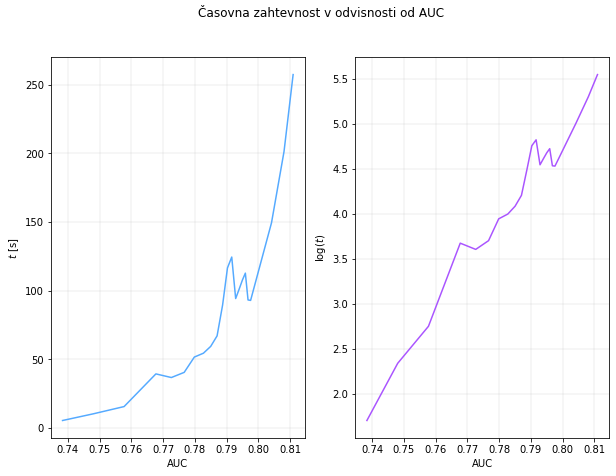

In [ ]:
# ........ Time complexity vs AUC

fig, ax = plt.subplots(1,2, figsize = (10,7))
fig.suptitle("Časovna zahtevnost v odvisnosti od AUC")

ax[0].grid(lw = 0.2)
ax[1].grid(lw = 0.2)

ax[0].set_xlabel("AUC")
ax[0].set_ylabel("$t$ [s]")
ax[0].plot(auc_metrics, time_complexity, color=cmap(1))

log_time = np.log(time_complexity)
ax[1].set_xlabel("AUC")
ax[1].set_ylabel("log($t$)")
ax[1].plot(auc_metrics, log_time, color=cmap(2))

plt.savefig('grafi/time_compexity_auc.pdf')
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7130603	best: 0.7130603 (0)	total: 140ms	remaining: 13.8s
1:	test: 0.7267641	best: 0.7267641 (1)	total: 313ms	remaining: 15.4s
2:	test: 0.7284153	best: 0.7284153 (2)	total: 425ms	remaining: 13.7s
3:	test: 0.7298327	best: 0.7298327 (3)	total: 518ms	remaining: 12.4s
4:	test: 0.7295820	best: 0.7298327 (3)	total: 608ms	remaining: 11.6s
5:	test: 0.7294615	best: 0.7298327 (3)	total: 700ms	remaining: 11s
6:	test: 0.7301931	best: 0.7301931 (6)	total: 801ms	remaining: 10.6s
7:	test: 0.7305530	best: 0.7305530 (7)	total: 899ms	remaining: 10.3s
8:	test: 0.7302167	best: 0.7305530 (7)	total: 992ms	remaining: 10s
9:	test: 0.7307020	best: 0.7307020 (9)	total: 1.09s	remaining: 9.8s
10:	test: 0.7302233	best: 0.7307020 (9)	total: 1.19s	remaining: 9.61s
11:	test: 0.7307809	best: 0.7307809 (11)	total: 1.27s	remaining: 9.33s
12:	test: 0.7309509	best: 0.7309509 (12)	total: 1.36s	remaining: 9.13s
13:	test: 0.7307374	best: 0.7309509 (12)	total: 1.52s	remaining: 9.33s
14:	test: 0.7310515	best: 0.7310

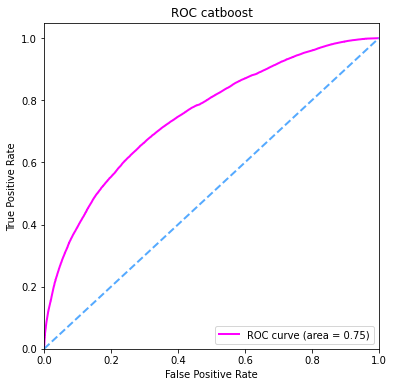

grafi/bdt_roc_10_100.pdf


In [ ]:
# ROC
from sklearn.metrics import *

data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
n_dims=data_fnames.shape[0]
x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample
pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())

max_d = 10
max_t = 100

bdt =trees_params(max_d, max_t)# random default values
y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
fake, true, _ = roc_curve(y_val,y_score)
roc_auc = auc(fake,true)
plt.figure(figsize=[6, 6])
lw=2

plt.plot(fake, true, color=cmap(3),lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color=cmap(1), lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC catboost")
plt.legend(loc="lower right")

plt.savefig(f'grafi/bdt_roc_{max_d}_{max_t}.pdf')
plt.show()
print(f'grafi/bdt_roc_{max_d}_{max_t}.pdf')

## Deep Neural network

In [ ]:
# get data
hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample


# ready the data for TF
ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy()))
ds_train = ds_train.repeat()
ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy()))
ds_test = ds_test.repeat()
ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

train_steps=int(x_train.shape[0]/BATCH_SIZE)
test_steps=int(x_test.shape[0]/BATCH_SIZE)

Loading c:\Users\lotri\Downloads\collab_v2\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']


In [ ]:
# number of layers
from datetime import datetime
time_complexity = dict()
nepoch = 20
auc = dict()
for n in range(1,20):
    dnn = Sequential()
    for i in range(n):
        dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )
    
    start = datetime.now()
    dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )
    time_complexity[n] = (datetime.now()- start).total_seconds()
    
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc[n] = roc_auc_score(y_val,y_score) # n + 1 output layer

Epoch 1/20
3600/3600 [==============================] - 13s 3ms/step - loss: 0.6012 - accuracy: 0.6769 - auc: 0.7397 - binary_crossentropy: 0.6012 - val_loss: 0.5766 - val_accuracy: 0.7027 - val_auc: 0.7684 - val_binary_crossentropy: 0.5766
Epoch 2/20
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5681 - accuracy: 0.7071 - auc: 0.7768 - binary_crossentropy: 0.5681 - val_loss: 0.5624 - val_accuracy: 0.7126 - val_auc: 0.7818 - val_binary_crossentropy: 0.5624
Epoch 3/20
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5576 - accuracy: 0.7138 - auc: 0.7860 - binary_crossentropy: 0.5576 - val_loss: 0.5555 - val_accuracy: 0.7165 - val_auc: 0.7878 - val_binary_crossentropy: 0.5555
Epoch 4/20
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5521 - accuracy: 0.7173 - auc: 0.7907 - binary_crossentropy: 0.5521 - val_loss: 0.5515 - val_accuracy: 0.7199 - val_auc: 0.7911 - val_binary_crossentropy: 0.5515
Epoch 5/20
3600/3600 [==============

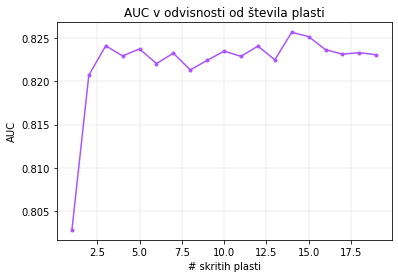

In [ ]:
cmap = plt.get_cmap('cool', 4)

plt.title("AUC v odvisnosti od števila plasti")
plt.xlabel("# skritih plasti")
plt.ylabel("AUC")
plt.grid(lw = 0.2)
plt.plot(auc.keys(), auc.values(), marker='.', color = cmap(2))

plt.savefig('grafi/layers_auc.pdf')
plt.show()

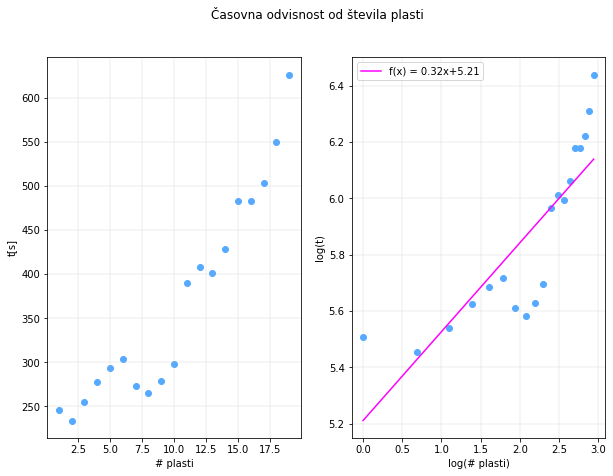

In [ ]:
# plot time complexity

from scipy.optimize import curve_fit
def linear(x,a,b):
    return a*x + b

fig, ax = plt.subplots(1,2, figsize = (10,7))
fig.suptitle("Časovna odvisnost od števila plasti")

ax[0].grid(lw = 0.2)
ax[1].grid(lw = 0.2)

ax[0].set_xlabel("# plasti")
ax[0].set_ylabel("t[s]")
ax[0].scatter(time_complexity.keys(), time_complexity.values(), color=cmap(1))

log_time = [np.log(i) for i in time_complexity.values()]
x = [np.log(i) for i in time_complexity.keys()]
params, pcov = curve_fit(linear, x, log_time)
y = [linear(i, *params) for i in x]
ax[1].plot(x, y, label = f"f(x) = {params[0].round(2)}x+{params[1].round(2)}", color=cmap(3))

ax[1].set_xlabel("log(# plasti)")
ax[1].set_ylabel("log(t)")
ax[1].scatter(x, log_time, color=cmap(1))
ax[1].legend()

plt.savefig('grafi/timecomplexity_layers.pdf')
plt.show()

In [ ]:
# number of perceptrons, 3 layers

nepoch = 10
auc = dict()
for n in range(1,200,25):
    dnn = Sequential()
    dnn.add(Dense(n, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(n, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )
    dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc[n] = roc_auc_score(y_val,y_score) # n + 1 output layer

#!matplotlib inline

Epoch 1/10
3600/3600 [==============================] - 13s 3ms/step - loss: 0.6555 - accuracy: 0.6148 - auc: 0.6372 - binary_crossentropy: 0.6555 - val_loss: 0.6399 - val_accuracy: 0.6372 - val_auc: 0.6684 - val_binary_crossentropy: 0.6399
Epoch 2/10
3600/3600 [==============================] - 10s 3ms/step - loss: 0.6397 - accuracy: 0.6388 - auc: 0.6735 - binary_crossentropy: 0.6397 - val_loss: 0.6347 - val_accuracy: 0.6495 - val_auc: 0.6812 - val_binary_crossentropy: 0.6347
Epoch 3/10
3600/3600 [==============================] - 8s 2ms/step - loss: 0.6384 - accuracy: 0.6444 - auc: 0.6764 - binary_crossentropy: 0.6384 - val_loss: 0.6344 - val_accuracy: 0.6517 - val_auc: 0.6815 - val_binary_crossentropy: 0.6344
Epoch 4/10
3600/3600 [==============================] - 9s 2ms/step - loss: 0.6383 - accuracy: 0.6458 - auc: 0.6758 - binary_crossentropy: 0.6383 - val_loss: 0.6344 - val_accuracy: 0.6523 - val_auc: 0.6807 - val_binary_crossentropy: 0.6344
Epoch 5/10
3600/3600 [================

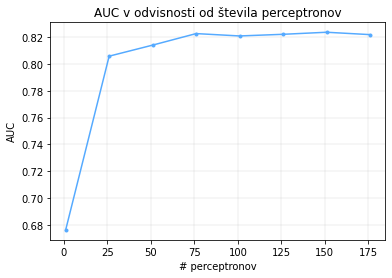

In [ ]:
cmap = plt.get_cmap('cool', 4)

plt.title("AUC v odvisnosti od števila perceptronov")
plt.xlabel("# perceptronov")
plt.ylabel("AUC")
plt.grid(lw = 0.2)
plt.plot(auc.keys(), auc.values(), marker='.', color=cmap(1))

plt.savefig('grafi/auc_perceptrons.pdf')
plt.show()

In [ ]:
# epoch

nepoch = 10
auc = dict()
for n in range(1,50,5):
    nepoch = n
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )
    dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc[n] = roc_auc_score(y_val,y_score) # n + 1 output layer

3125/3125 [==============================] - 6s 2ms/step
Epoch 1/6
3600/3600 [==============================] - 12s 3ms/step - loss: 0.5812 - accuracy: 0.6931 - auc: 0.7605 - binary_crossentropy: 0.5812 - val_loss: 0.5603 - val_accuracy: 0.7119 - val_auc: 0.7841 - val_binary_crossentropy: 0.5603
Epoch 2/6
3600/3600 [==============================] - 11s 3ms/step - loss: 0.5497 - accuracy: 0.7183 - auc: 0.7919 - binary_crossentropy: 0.5497 - val_loss: 0.5481 - val_accuracy: 0.7214 - val_auc: 0.7956 - val_binary_crossentropy: 0.5481
Epoch 3/6
3600/3600 [==============================] - 11s 3ms/step - loss: 0.5394 - accuracy: 0.7249 - auc: 0.8009 - binary_crossentropy: 0.5394 - val_loss: 0.5407 - val_accuracy: 0.7261 - val_auc: 0.8016 - val_binary_crossentropy: 0.5407
Epoch 4/6
3600/3600 [==============================] - 11s 3ms/step - loss: 0.5330 - accuracy: 0.7294 - auc: 0.8063 - binary_crossentropy: 0.5330 - val_loss: 0.5351 - val_accuracy: 0.7303 - val_auc: 0.8060 - val_binary_cros

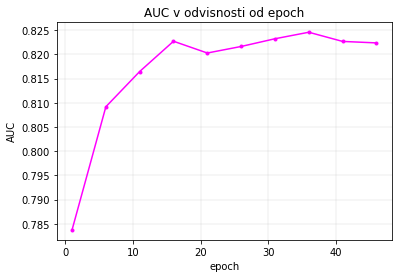

In [ ]:
cmap = plt.get_cmap('cool', 4)

plt.title("AUC v odvisnosti od epoch")
plt.xlabel("epoch")
plt.ylabel("AUC")
plt.grid(lw = 0.2)
plt.plot(auc.keys(), auc.values(), marker='.', color = cmap(3))

plt.savefig('grafi/auc_epoch.pdf')
plt.show()

In [ ]:
# plot roc
nepoch = 10
perc = 50

dnn = Sequential()
dnn.add(Dense(perc, input_dim=n_dims, activation='relu'))
dnn.add(Dense(perc, input_dim=n_dims, activation='relu'))
dnn.add(Dense(1, activation='sigmoid')) # output layer/value
dnn.compile(optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'binary_crossentropy'])
eval_metric = 'AUC'
earlystop_callback = EarlyStopping(
    mode='max',
    monitor='val_' + eval_metric,
    patience=5,
    min_delta=0.00001,
    verbose=1
)
dnn.fit(ds_train,
    epochs=nepoch,
    steps_per_epoch=train_steps,
    #callbacks=[earlystop_callback],
    validation_data=ds_test,
    validation_steps=test_steps
)
y_score=dnn.predict(x_val.to_numpy())[:,0]
# plot ROC
from sklearn.metrics import roc_auc_score,roc_curve,auc
fake, true, _ = roc_curve(y_val,y_score)
roc_auc = auc(fake,true)

Epoch 1/10
3600/3600 [==============================] - 12s 3ms/step - loss: 0.5846 - accuracy: 0.6890 - auc: 0.7563 - binary_crossentropy: 0.5846 - val_loss: 0.5565 - val_accuracy: 0.7162 - val_auc: 0.7873 - val_binary_crossentropy: 0.5565
Epoch 2/10
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5480 - accuracy: 0.7194 - auc: 0.7931 - binary_crossentropy: 0.5480 - val_loss: 0.5428 - val_accuracy: 0.7225 - val_auc: 0.7992 - val_binary_crossentropy: 0.5428
Epoch 3/10
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5378 - accuracy: 0.7255 - auc: 0.8021 - binary_crossentropy: 0.5378 - val_loss: 0.5360 - val_accuracy: 0.7277 - val_auc: 0.8050 - val_binary_crossentropy: 0.5360
Epoch 4/10
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5319 - accuracy: 0.7301 - auc: 0.8071 - binary_crossentropy: 0.5319 - val_loss: 0.5320 - val_accuracy: 0.7314 - val_auc: 0.8086 - val_binary_crossentropy: 0.5320
Epoch 5/10
3600/3600 [==============

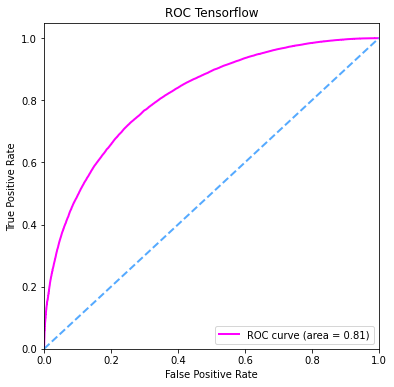

In [ ]:
cmap = plt.get_cmap('cool', 4)

plt.figure(figsize=[6, 6])
lw=2

plt.plot(fake, true, color=cmap(3),lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color=cmap(1), lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Tensorflow")
plt.legend(loc="lower right")

plt.savefig(f'grafi/roc_dnn_e{nepoch}_p{perc}.pdf')
plt.show()